# Names Generator v3 - Batchnorm 

Improving our model by:
* Improving initialisation: fixing initial loss by making logits uniform at the start > prevent very confident mispredictions > avoid hockey stick losses where some training is spent doing wasteful work
* Improving initialisation: fixing saturated tanh to ensure activations are roughly gaussian > not too large or small so they dont explode to infinity or squash to zero after nonlinearities 
* Adding BatchNorm: fix saturated tanh and make the activations gaussian by centering them using mean and std 

1. Input
2. Embedding table
3. Hidden layer - **improve initialisation** (NEW)
4. **BatchNorm layer** (NEW)
5. Output layer - **improve initialisation** (NEW)
6. Softmax layer

In [3]:
# imports
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 

# read all the words 
words = open('data/names.txt', 'r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [3]:
# build vocab of characters
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [32]:
# build the dataset 
block_size = 3 

def build_dataset(words): 
    X, Y = [], []

    for w in words: 
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y 

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 80%, 
Xdev, Ydev = build_dataset(words[n1:n2])    # 10% 
Xts, Yts = build_dataset(words[n2:])        # 10% 

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [ ]:
# MLP 
n_embed = 10    # dimentionality of character embedding vectors 
n_hidden = 200  # num neurons in hidden layer 

g = torch.Generator().manual_seed(2147483647) # for reproducability 
C = torch.randn((vocab_size, n_embed),              generator=g) 
W1 = torch.randn((block_size * n_embed, n_hidden),  generator=g) * (5/3)/((n_embed*block_size)**0.5) # kaiming normal initialisation
#b1 = torch.randn((n_hidden),                       generator=g) * 0.01                              # batch normalisation negates effect of this bias
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # make small to fix initial loss 
b2 = torch.randn((vocab_size),                      generator=g) * 0    # make small to fix initial loss 

# BatchNorm parameters 
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total num params
for p in parameters: 
    p.requires_grad = True

12097


In [37]:
# Optimisation 
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps): 

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Xb (32, 3), Yb (32, 1)
    
    # forward pass 
    emb = C[Xb] # emb (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # concatenate to (32, 3*10)
    # -- linear layer 
    hpreact = embcat @ W1 # hidden layer pre-activation
    # -- BatchNorm layer
    bnmeani = hpreact.mean(0, keepdim=True) 
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias  
    with torch.no_grad(): # update running mean and std to be used in test time
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -- nonlinearity (activation)
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)

    # backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward()

    # update 
    lr = 0.1 if i<100000 else 0.01 # step learning rate decay 
    for p in parameters: 
        p.data += -lr * p.grad 
    
    # track stats
    if i % 10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.2856
  10000/ 200000: 2.1340
  20000/ 200000: 2.1373
  30000/ 200000: 2.2285
  40000/ 200000: 2.0133
  50000/ 200000: 1.7307
  60000/ 200000: 2.2741
  70000/ 200000: 2.2340
  80000/ 200000: 2.3828
  90000/ 200000: 2.0722
 100000/ 200000: 2.2072
 110000/ 200000: 2.1703
 120000/ 200000: 2.2788
 130000/ 200000: 1.8803
 140000/ 200000: 1.7875
 150000/ 200000: 2.1805
 160000/ 200000: 1.9339
 170000/ 200000: 1.9587
 180000/ 200000: 2.1038
 190000/ 200000: 2.0363


In [38]:
# Test time
@torch.no_grad() # this decorated disables gradient tracking 
def split_loss(split): 
    x, y = {
        'train': (Xtr, Ytr), 
        'val': (Xdev, Ydev), 
        'test': (Xts, Yts)
    } [split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
    hpreact = embcat @ W1 
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # BN 
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0657238960266113
val 2.109696865081787


### Fixing initial loss

* Originally, we see that initial loss is very high (~24), which is unexpected 

* Expected loss: at initialisation , probability distribtuion should be unifrom distrib (1/27) because no reason to believe any char is more likely than the other

* Expected loss = nll = `-torch.tensor(1/27.0).log()` --> 3.2958

* Whats happening is that the nn initialises randomly. Some chars are very confident (high prob) and others are very unconfident, and nn is very confidently wrong, which leads to high loss. 

* We want the logits to be roughly zero, so that probabilities are uniform.

How to fix? 

* logits = h @ W2 + b2 --> want logits to all equal. for symmetry try to make them all 0,and to do that need to make b2=0 and W2 small eg. 0.01

* When initialisation is better, we spend more time doing productive training instead of learning overconfidence and squashing weights down 

### Fixing the saturated tanh 

* We see below that most of the values of h take on values around -1 and 1 

* This is becayse tanh squeezes and caps hpreact to between -1 and 1. since hpreact takes on quite a large range from -15 to 15 (plot to see), many tan(hpreact) values are at squeezed to -1 or 1

Why is this a problem? 
* During back propagation through torch.tanh, `self.grad += (1-t**2) * out.grad` 

* When t = 1 or -1, self.grad += 0 - killing the gradient (makes sense bc if output v close to 1, then its in the tail/flat region of tanh, changing the input wont change the output that much, hence loss wont change much, hance grad wrt loss is 0. Gradients get destroyed 

* **Dead neuron**: If in one tanh neuron, all the activations (h) lie in the tail, it means that no single example ever activates that neuron - no gradient flows through - neuron will never learn and change

* Sometimes in optimisation, if too high learning rate, neuron gets knocked out of data manifold - no example ever activates that neuron from then on


How to solve 

* hpreact is too far from zero and range is too large.

* hpreact = h @ W1 + b1 --> want logits to be 0, need to make b2=0.01 and W2 small eg. 0.1

(array([2150.,  153.,   90.,   67.,   67.,   50.,   35.,   32.,   29.,
          23.,   29.,   32.,   20.,   26.,   18.,   24.,   24.,   24.,
          24.,   20.,   21.,   29.,   23.,   15.,   14.,   11.,   17.,
          19.,   23.,   18.,   10.,   27.,   23.,   23.,   23.,   20.,
          28.,   22.,   31.,   32.,   30.,   41.,   29.,   39.,   38.,
          76.,   81.,  119.,  152., 2429.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

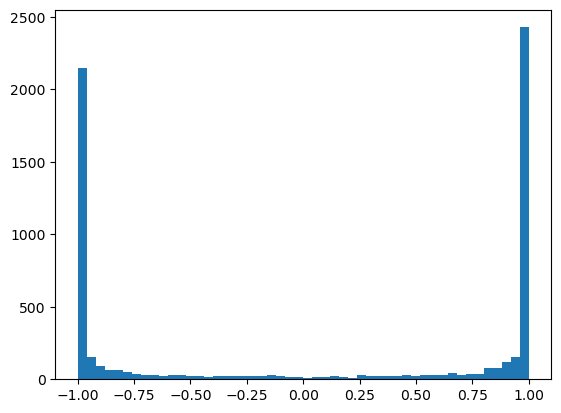

In [ ]:
# Before fixing saturated tanh: h values
plt.hist(h.view(-1).tolist(),50)

(array([170., 206., 172., 144., 166., 133., 149., 126., 127., 121., 106.,
        109., 129.,  94., 128., 103., 109.,  86., 112.,  83., 100.,  75.,
         99.,  88.,  87., 112.,  83., 130., 115.,  95., 108., 106., 118.,
         94.,  99., 126.,  85., 126., 124., 113., 122., 120., 143., 158.,
        165., 192., 182., 176., 257., 229.]),
 array([-9.99114394e-01, -9.59151689e-01, -9.19188983e-01, -8.79226278e-01,
        -8.39263573e-01, -7.99300867e-01, -7.59338162e-01, -7.19375457e-01,
        -6.79412751e-01, -6.39450046e-01, -5.99487340e-01, -5.59524635e-01,
        -5.19561930e-01, -4.79599224e-01, -4.39636519e-01, -3.99673814e-01,
        -3.59711108e-01, -3.19748403e-01, -2.79785697e-01, -2.39822992e-01,
        -1.99860287e-01, -1.59897581e-01, -1.19934876e-01, -7.99721706e-02,
        -4.00094652e-02, -4.67598438e-05,  3.99159455e-02,  7.98786509e-02,
         1.19841356e-01,  1.59804062e-01,  1.99766767e-01,  2.39729472e-01,
         2.79692178e-01,  3.19654883e-01,  3.59617

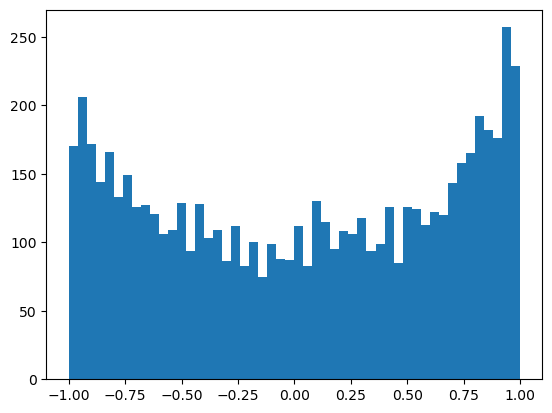

In [ ]:
# After fixing saturated tanh: h values
plt.hist(h.view(-1).tolist(),50)

## Introducing Kaiming Normal Initialisation 

Overall, we want the activations throughout a nn be Gaussian-like and have 0 mean and unit variance (std close to 1). This is so that we can **avoid exploding or vanishing signals** - If the outputs (activations) of each layer grow too large or shrink too small, the gradients during backpropagation also explode or vanish. This makes learning unstable or completely breaks it.

Problem: 
* Matrix multiplication increases variance by a factor of fan_in (number of inputs to the layer)
* with input vector x (mean=0, var_x) and weights matrix w (mean=0, var_w), pre-activation output z has (mean=0, var_z = fan_in * var_x * var_w). The variance grows with the input dimensionality (fan-in). Without correction, this leads to exploding or vanishing signals as the network deepens

Solution: 
* To preserve variance, we want var_z = var_x, meaning var_w = 1/fan_in. So `std_w = 1/(fan_in**0.5)`
* However, there is a catch. Activations like ReLU, Leaky ReLU, and tanh are contractive — they shrink the variance of their inputs. To compensate for that contraction, we scale up the weights a bit — that’s where the gain comes in. 
* Different activation functions have diff gain (tanh gain = 5/3, ReLU gain = 2**0.5, linear gain = 1)

Final formula: `std_w = gain/(fan_in**0.5)`

This is what **PyTorch's Kaiming Normal Initialization** does. 
`torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')`
is used to initialize neural network weights in a way that maintains stable signal propagation, meaning outputs of each layer have std close to 1. 


## Introducing Batch Normalisation 

Going back to our original aim, we want the pre-activation outputs (hpreact) to be roughly Gaussian (because if too small, tanh activation is useless, but if too large tanh is saturated). Batch Normalization (BN) says we can do this by just **standardising the outputs to be unit Gaussian**.

#### What BatchNorm essentially does:
>```python
># Given hpreact.shape --> (32, 200)
># Compute the mean and standard deviation across the batch for each neuron
>mean = hpreact.mean(0, keepdim=True).shape --> (1, 200)
>std = hpreact.std(0, keepdim=True).shape --> (1, 200)
># Standardise hpreact to Gaussian
>hpreact = (hpreact - mean)/ std
>```

However, we only want hpreact to be Gaussian at initialisation. During training, we want backpropagation to shape the distribution. So we introduce learnable parameters (scale and shift)
> ```python 
> bngain = torch.ones((1, n_hidden))
> bnbias = torch.zeros((0, n_hidden))
> # New computation 
> hpreact = bngain * (hpreact - mean)/ std + bnbias 
> ```
At initialisation, bngain=1 and bnbias=0, hence output values are exactly unit gaussian. During optimisation, we can back propagate into bngain and bnbias to change them (they are now also params of the nn), which allows hpreact to not be fixed at exactly gaussian and can move around. 

Summary of BatchNorm: 
* It is common to have it sprinkled across a neural net, and we will usually place it after layers with multiplications (linear or convolutional layers) 
* Make activation scales consistent and prevent exploding or vanishing gradients

#### Caveat: BatchNorm Ties Together Examples in a Batch**

Because BN uses the mean and std across the whole batch, the activations for one example now depend on the others in the same batch. This has 2 effects 
* ✅ Acts like regularization - hpreact and logits will jitter for each example due to varying batch stats. This acts like noise injection or data augmentation and reduces overfitting to any one example 
* ❌ Makes inference harder - During evaluation, you usually want to feed in a single example. But now the model expects a batch as input to compute mean and std 

Solution: Use Fixed BatchNorm Stats at Test Time 

Two common approaches:
* **Post-hoc**: After training,  get preact for each example in the training set and compute the true mean and std of over the full training set (see below), and use that for inference
* **Running estimate**: During training, maintain a running average of batch means and stds. These are then used during evaluation (default in PyTorch, see our above imple)

This makes the model work correctly even on a single test example.

In [ ]:
# Post hoc calculation of BN mean and std 
with torch.no_grad(): 
    # pass the training set through 
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    # measure mean and std over entire training set 
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

# in test time, use bnmean and bnstd for BN

## Pytorchifying our code

**PyTorch layers:**

Linear: 
`torch.nn.Linear(fan_in, fan_out, bias = True)`
* fan_in and fan_out: used to initialise W1 = torch.randn(block_size * n_embed, n_hidden)
* bias: True: have bias 

Variables: 
* Weights: initialised from U(-k**0.5, k **0.5), where k = 1/fan_in. similar to ours, except instead gain=1 and using uniform distrib instead of gaussian distrib 

BatchNorm: 
`torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)`
* num_features (=200 for us): used to initialise bngain, bnbias, bnmean_running and bnstd_running 
* momentum: used to update running mean and std (eg. momentum = 0.1 means bnmean_running = 0.9*bnmeanstd + 0.1 *bnmeani) -- large batch size: can use higher momentum. small batch size: use smaller momentum so that running mean and std is not thrashing too much and is actually converging properly 
* track_running_stats: whether to track running mean and std
* device: GPU or CPU 

In [44]:
# Make linear, batchnorm and tanh into layers so that we can stack them in a list 

class Linear: 
    
    def __init__(self, fan_in, fan_out, bias=True): 
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None 

    def __call__(self, x): 
        self.out = x @ self.weight
        if self.bias is not None: 
            self.out += self.bias 
        return self.out 

    def parameters(self): 
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d: 

    def __init__(self, dim, eps=1e-5, momentum=0.1): 
        self.eps = eps
        self.momentum = momentum 
        self.training = True # flag to determine if BN is called during training or test (behaves differently in both)
        # params (trained with backprop)
        self.gamma = torch.ones(dim) #bngain 
        self.beta = torch.zeros(dim) #bnbias 
        #buffers (trained with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x): 
        # forward pass 
        if self.training: 
            xmean = x.mean(0, keepdim=True) # batch mean 
            xvar = x.var(0, keepdim=False) # batch variance 
        else: 
            xmean = self.running_mean
            xvar = self.running_var 
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) 
        self.out = self.gamma * xhat + self.beta 
        # update buffers 
        if self.training: 
            with torch.no_grad(): 
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        return self.out 
    
    def parameters(self):
        return [self.gamma, self.beta]
 

class Tanh: 
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out 
    def parameters(self):
        return []

In [100]:
n_embed = 10 # dimentionality of embedding vectors for the chars 
n_hidden = 100 # num neurons in hidden layer of MLP 
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g) # embeddings for each char 

layers = [
    Linear(n_embed * block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(            n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(            n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(            n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(            n_hidden, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(            n_hidden, vocab_size, bias = False), BatchNorm1d(vocab_size) 
]
'''
layers = [
    Linear(n_embed * block_size, n_hidden, bias = False), Tanh(), 
    Linear(            n_hidden, n_hidden, bias = False), Tanh(), 
    Linear(            n_hidden, n_hidden, bias = False), Tanh(), 
    Linear(            n_hidden, n_hidden, bias = False), Tanh(), 
    Linear(            n_hidden, n_hidden, bias = False), Tanh(), 
    Linear(            n_hidden, vocab_size, bias = False),
]
'''
with torch.no_grad(): 
    # last layer: make less confident 
    # layers[-1].weight *= 0.1 
    layers[-1].gamma *= 0.1 
    # for all linear layers, apply gain for kaiming normal initialisation
    gain = 5/3
    for layer in layers[:-1]: 
        if isinstance(layer, Linear): 
            layer.weight *= gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print (sum(p.nelement() for p in parameters)) # total num of params 
for p in parameters: 
    p.requires_grad = True 


47024


In [101]:
# Optimisation 

max_steps = 200000
batch_size = 32 
lossi = []
ud = []

for i in range(max_steps): 

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g) # random indexes 
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y 
    
    # forward pass 
    emb = C[Xb]                     # embed chars into vectors 
    x = emb.view(emb.shape[0], -1)  # concat vectors 
    for layer in layers:            # pass thru layers 
        x = layer(x)    
    loss = F.cross_entropy(x, Yb)   # loss func 

    # backward pass 
    for layer in layers: 
        layer.out.retain_grad()     # for every layer, get outputs and retain gradients - WHY? 
    for p in parameters: 
        p.grad = None 
    loss.backward()

    # update 
    lr = 0.1 if i<150000 else 0.01  # lr decay 
    for p in parameters: 
        p.data += - lr * p.grad

    # track stats
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad(): 
        # track ratio of size of each update:data using std 
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i>=1000: # take out after debug to run full optimisation 
        break 

      0/ 200000: 3.3313


### Diagnostic tools 
To check if NN is in a good state (look at activations, gradients, weights, ratio of gradients to data and ratios updates to data )

In [ ]:
def plot_histograms(data_list, labels, title, xlabel, threshold=None):
    """Generic histogram plotter."""
    plt.figure(figsize=(20, 4))
    for data, label in zip(data_list, labels):
        hy, hx = torch.histogram(data, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=label)
    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()

def plot_activation_histograms(layers, threshold=0.97, title=None):
    data_list, labels = [], []
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, Tanh):
            t = layer.out
            mean, std = t.mean().item(), t.std().item()
            saturation = (t.abs() > threshold).float().mean().item() * 100
            print(f"Layer {i:2d} ({layer.__class__.__name__:>10}): "
                  f"mean {mean:+.2f}, std {std:.2f}, saturated: {saturation:.2f}%")
            data_list.append(t)
            labels.append(f"Layer {i} ({layer.__class__.__name__})")
    plot_histograms(data_list, labels, 
                    title or f'Activation Distributions (Tanh, saturated > {threshold})', 
                    xlabel='Activation Value')


def plot_gradient_histograms(layers, title="Gradient Distributions", activation_type=Tanh):
    data_list, labels = [], []
    for i, layer in enumerate(layers[:-1]):
        if isinstance(layer, activation_type):
            g = layer.out.grad
            if g is None:
                print(f"Warning: No gradient found for layer {i} ({layer.__class__.__name__})")
                continue
            mean, std = g.mean().item(), g.std().item()
            print(f"Layer {i:2d} ({layer.__class__.__name__:>10}): mean {mean:+.6f}, std {std:.2e}")
            data_list.append(g)
            labels.append(f"Layer {i} ({layer.__class__.__name__})")
    plot_histograms(data_list, labels, title, xlabel="Gradient Value")


def plot_weight_gradients(parameters, title="Weight Gradient Distributions"):
    data_list, labels = [], []
    for i, p in enumerate(parameters):
        if p.grad is not None and p.ndim == 2:
            g = p.grad
            mean, std = g.mean().item(), g.std().item()
            ratio = std / p.std().item()
            print(f"Weight {str(tuple(p.shape)):>12} | "
                  f"mean {mean:+.6f} | std {std:.2e} | grad:data ratio {ratio:.2e}")
            data_list.append(g)
            labels.append(f"{i} {tuple(p.shape)}")
    plot_histograms(data_list, labels, title, xlabel="Gradient Value")

def plot_update_ratios(ud, parameters, title="Update-to-Data Ratio (log10 scale)"):
    """Plots log10 of update/data ratio over time for each parameter."""
    plt.figure(figsize=(20, 4))
    legends = []
    for i, p in enumerate(parameters):
        if p.ndim == 2:
            ratios = [ud_step[i] for ud_step in ud]
            plt.plot(ratios)
            legends.append(f'Param {i}')
    plt.axhline(-3, color='k', linestyle='--', label='1e-3 ref line')
    plt.legend(legends)
    plt.title(title)
    plt.xlabel('Training Step')
    plt.ylabel('log10(Update/Data)')
    plt.grid(True)
    plt.show()

### Visualising our forward pass (activations)

Layer  1 (      Tanh): mean -0.05, std 0.64, saturated: 5.12%
Layer  3 (      Tanh): mean +0.02, std 0.56, saturated: 0.53%
Layer  5 (      Tanh): mean -0.00, std 0.55, saturated: 1.16%
Layer  7 (      Tanh): mean -0.03, std 0.55, saturated: 1.00%
Layer  9 (      Tanh): mean -0.01, std 0.54, saturated: 0.53%


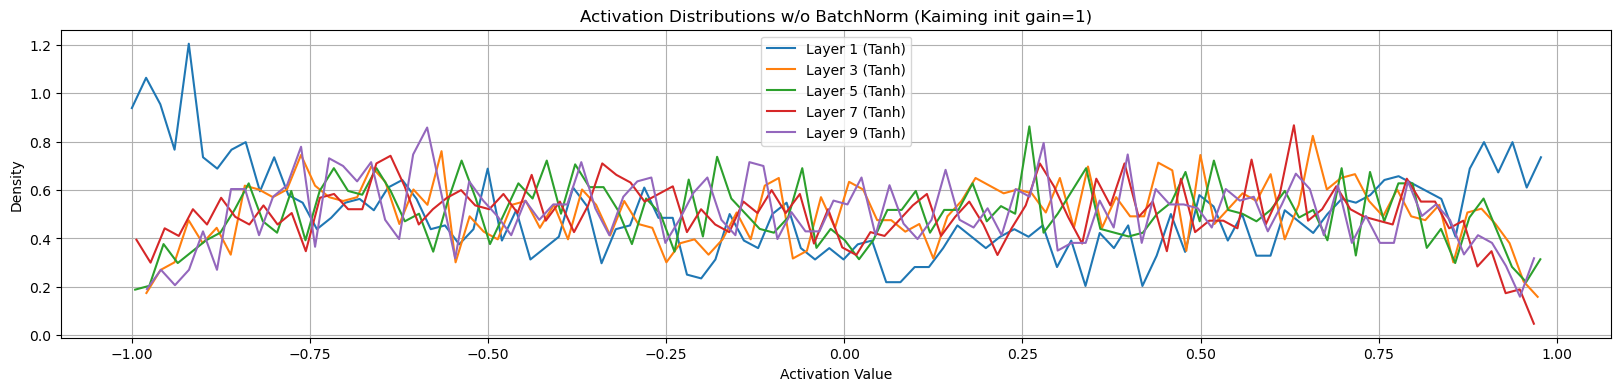

In [ ]:
# IF SET INCORRECT GAIN 
# -- gain too low (eg. 1), shrink - outputs will be squashed due to tanh function, std dev shrinks, tanh saturation level is low and shrinks to 0 
# -- gain too high (eg. 3), expand - outputs will explode and tanh func will be very saturated (many activations at -1 or 1)

plot_activation_histograms(layers, title="Activation Distributions w/o BatchNorm (Kaiming init gain=1)")

If remove tanh layer, forward pass collapses into one massive linear function (all the wx+b becomes a big wx + b)

Since it is linear the correct gain is 1. if gain is set too high then activations explode, if gain is too low then shrink. Before batch normalisation, this was a total balancing act 

However due to back pass, optimisation for 1 linear layer vs 10 linear layers is not identical due to how chain rule works. 

Layer  1 (      Tanh): mean -0.06, std 0.76, saturated: 21.84%
Layer  3 (      Tanh): mean +0.01, std 0.72, saturated: 11.72%
Layer  5 (      Tanh): mean -0.01, std 0.73, saturated: 14.31%
Layer  7 (      Tanh): mean -0.02, std 0.74, saturated: 14.56%
Layer  9 (      Tanh): mean -0.02, std 0.71, saturated: 10.53%


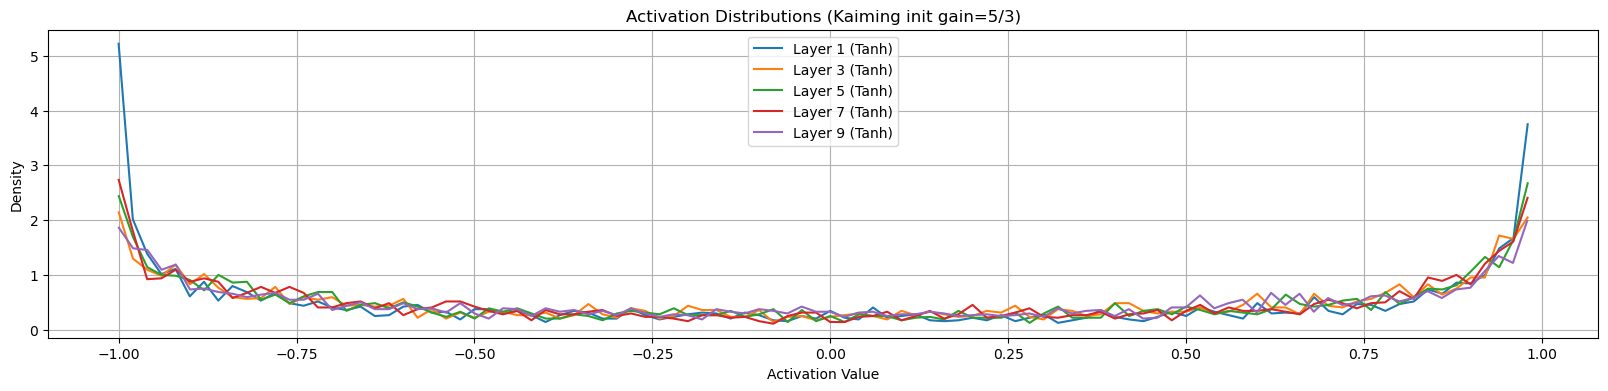

Layer  1 (      Tanh): mean -0.000035, std 3.41e-03
Layer  3 (      Tanh): mean -0.000043, std 3.15e-03
Layer  5 (      Tanh): mean +0.000023, std 2.96e-03
Layer  7 (      Tanh): mean -0.000011, std 2.90e-03
Layer  9 (      Tanh): mean +0.000014, std 2.36e-03


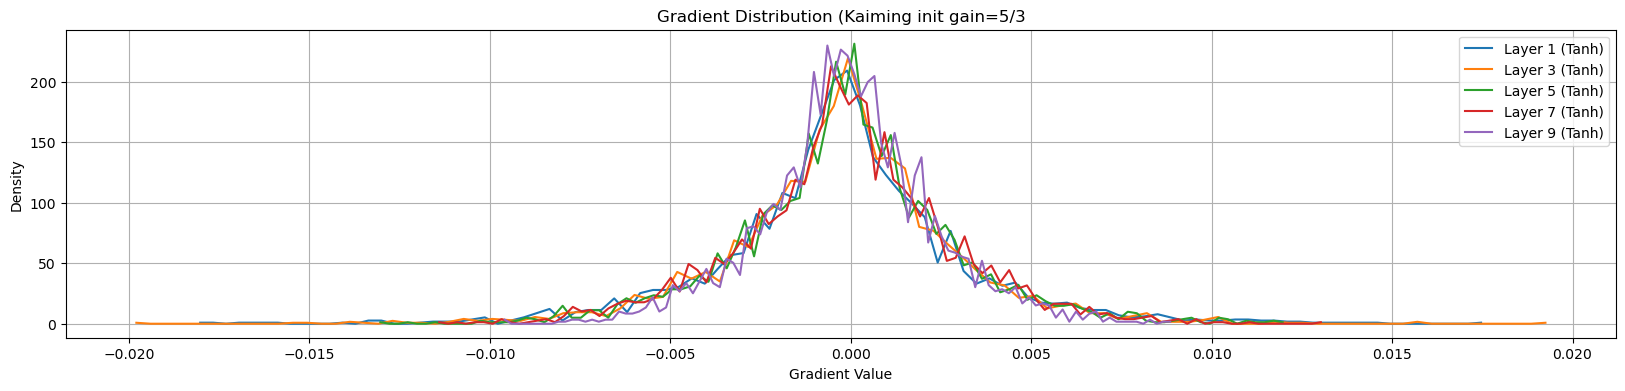

Weight     (27, 10) | mean -0.000667 | std 1.06e-02 | grad:data ratio 1.06e-02
Weight    (30, 100) | mean +0.000000 | std 9.78e-03 | grad:data ratio 3.12e-02
Weight   (100, 100) | mean -0.000023 | std 7.81e-03 | grad:data ratio 4.64e-02
Weight   (100, 100) | mean +0.000052 | std 6.54e-03 | grad:data ratio 3.86e-02
Weight   (100, 100) | mean -0.000042 | std 5.74e-03 | grad:data ratio 3.40e-02
Weight   (100, 100) | mean +0.000001 | std 4.92e-03 | grad:data ratio 2.92e-02
Weight    (100, 27) | mean -0.000000 | std 2.00e-02 | grad:data ratio 2.79e-01


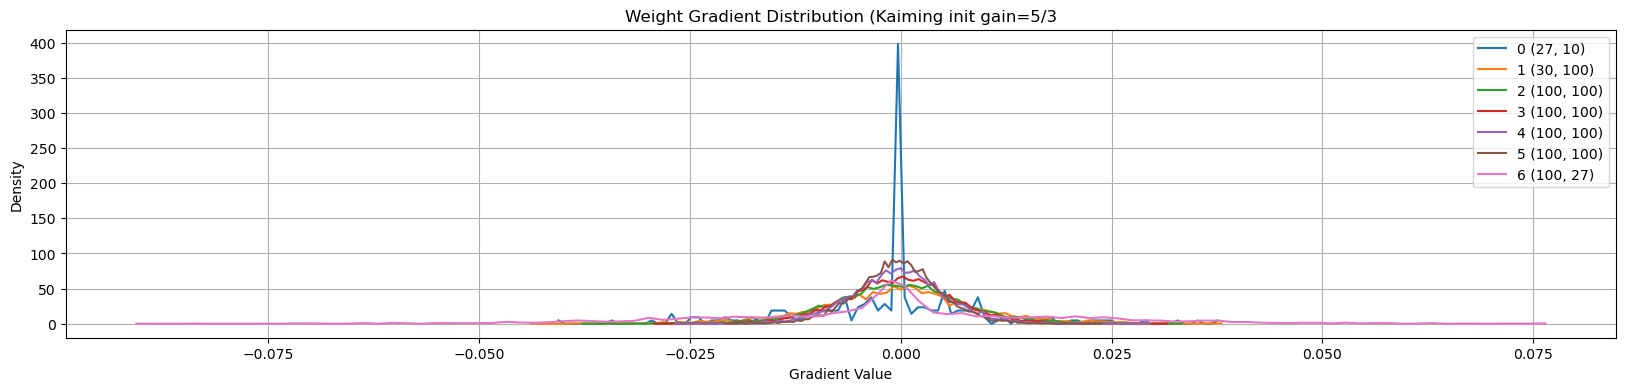

In [ ]:
# with correct gain = 5/3, no BatchNorm 

plot_activation_histograms(layers, title="Activation Distributions (Kaiming init gain=5/3)")
plot_gradient_histograms(layers, title="Gradient Distribution (Kaiming init gain=5/3")
plot_weight_gradients(parameters, title="Weight Gradient Distribution (Kaiming init gain=5/3")

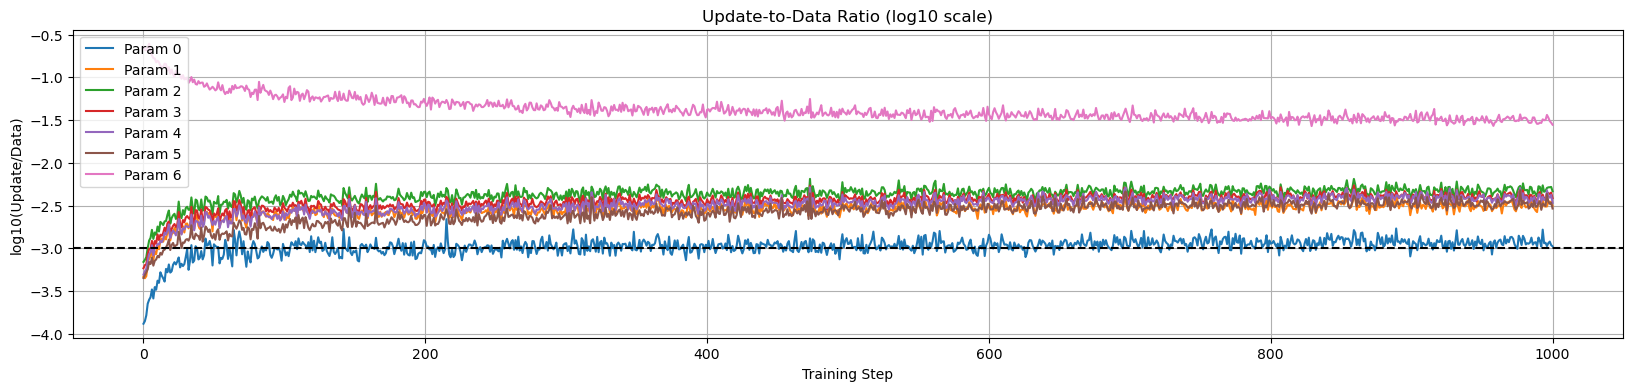

In [ ]:
plot_update_ratios(ud, parameters)

This graph plots the update to data ratio over time.  
* Dotted line is rough guide - ideally ratios should be ~1e-3. updates <= 0.001*actual data. 
* Final layer is outlier because we artificially made the weights *= 0.1 to make predictions less confident, so the data became smaller and ratios became bigger, but it stablises.
* Make sure that all the ratios are not too high above the dotted line. Currently it is a little bit on the higher side 
* If all the ratios are too far below dotted line, learning rate is too low and updates are too small. 

* If things are not calibrated properly: a lot of discrepancy between how 

When we have tanh, we can precisely calibrate the gains (=5/3) to make the activations, gradients and updates pretty decent 

With BatchNorm, we dont need to do that. Now for every tanh layer, there is a normalisation in the batchnorm, so the %saturation is going to look good. 
* A lot more robust and less affected by the gain, even if gain changes a lot, tanh is unaffected because of normalisation, hence activations, gradients and weights look ok
* Even if we take out the fan_in, things still look ok 
* However a wrong gain will still affect the updates ratio because of how the scale of the incoming activations interact in the BN and its backward pass. Change scale of updates on params. eg. higher gains lead to lower updates. 

Layer  2 (      Tanh): mean -0.00, std 0.64, saturated: 2.56%
Layer  5 (      Tanh): mean -0.01, std 0.64, saturated: 2.59%
Layer  8 (      Tanh): mean -0.01, std 0.64, saturated: 2.31%
Layer 11 (      Tanh): mean -0.01, std 0.64, saturated: 2.81%
Layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.34%


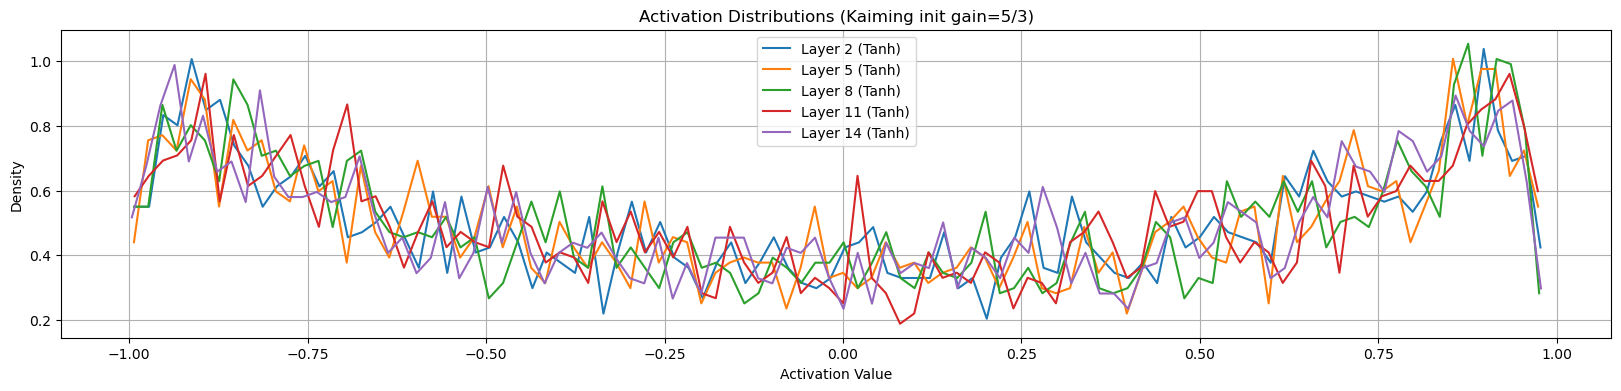

Layer  2 (      Tanh): mean -0.000000, std 3.86e-03
Layer  5 (      Tanh): mean +0.000000, std 3.31e-03
Layer  8 (      Tanh): mean -0.000000, std 3.11e-03
Layer 11 (      Tanh): mean -0.000000, std 2.75e-03
Layer 14 (      Tanh): mean +0.000000, std 2.49e-03


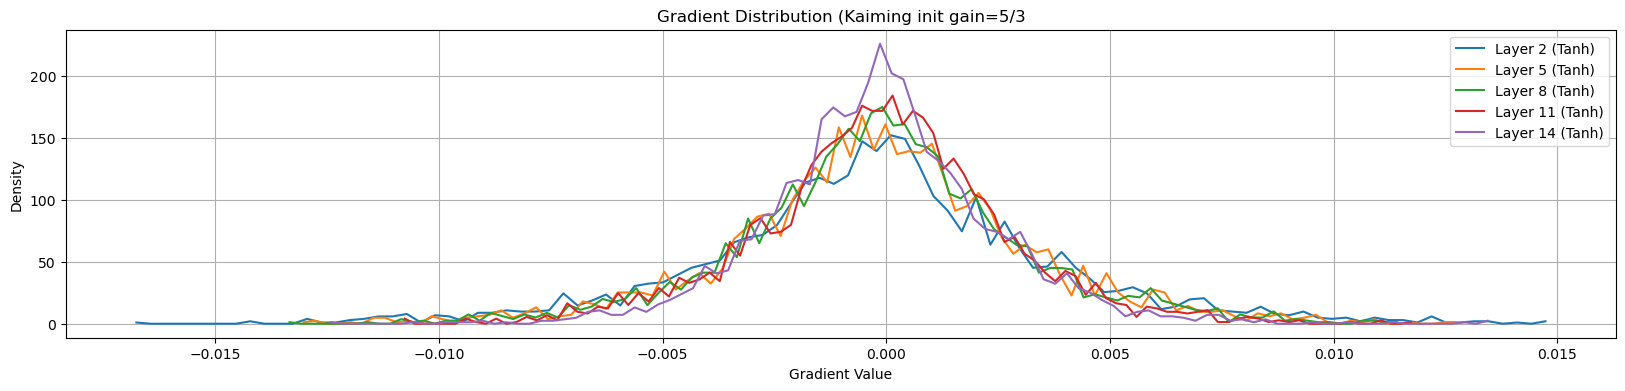

Weight     (27, 10) | mean +0.000000 | std 9.88e-03 | grad:data ratio 9.87e-03
Weight    (30, 100) | mean -0.000094 | std 8.75e-03 | grad:data ratio 2.80e-02
Weight   (100, 100) | mean +0.000160 | std 7.66e-03 | grad:data ratio 4.58e-02
Weight   (100, 100) | mean +0.000066 | std 6.82e-03 | grad:data ratio 4.04e-02
Weight   (100, 100) | mean +0.000010 | std 6.18e-03 | grad:data ratio 3.68e-02
Weight   (100, 100) | mean +0.000014 | std 5.33e-03 | grad:data ratio 3.18e-02
Weight    (100, 27) | mean -0.000046 | std 9.66e-03 | grad:data ratio 5.80e-02


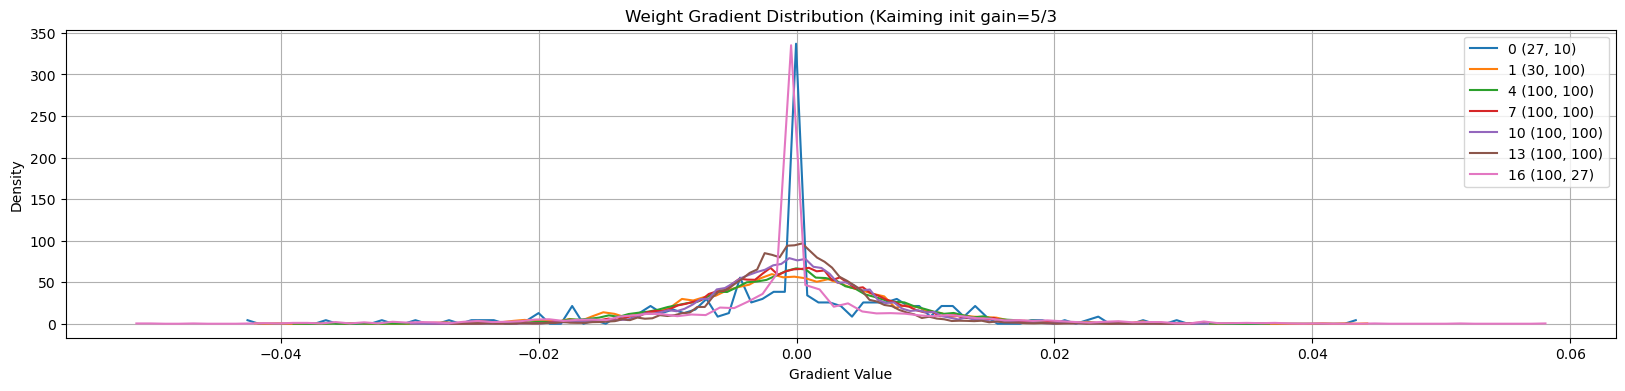

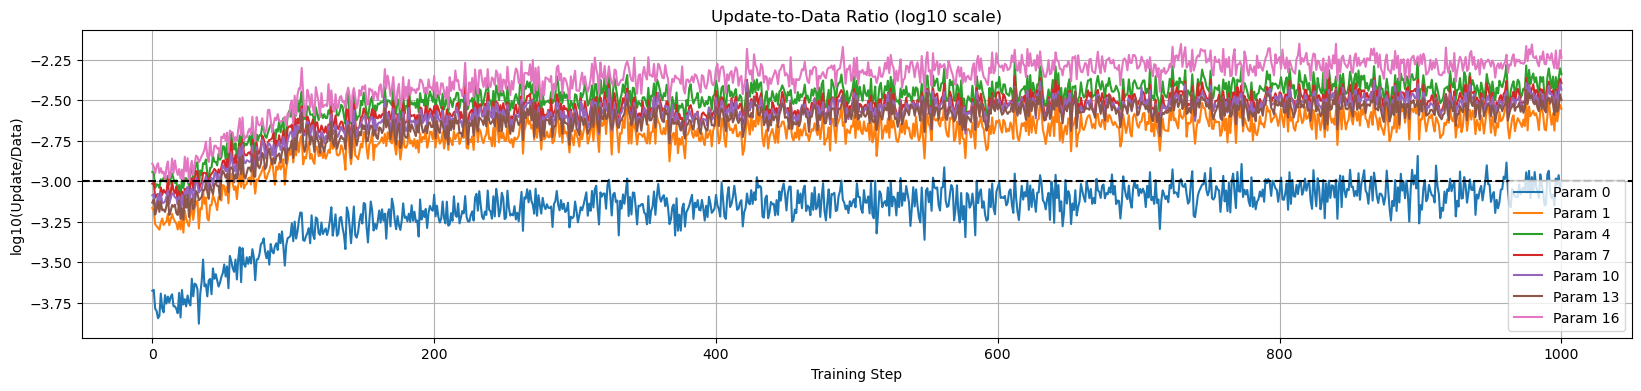

In [103]:
# with BatchNorm  

plot_activation_histograms(layers, title="Activation Distributions (Kaiming init gain=5/3)")
plot_gradient_histograms(layers, title="Gradient Distribution (Kaiming init gain=5/3")
plot_weight_gradients(parameters, title="Weight Gradient Distribution (Kaiming init gain=5/3")
plot_update_ratios(ud, parameters)